# Model Building

- Cluster common routes
- Build a model to predict traffic rating 
 - Build base line logistic regression model **(DONE)**
 - Build random forest classifier
 - Include Cross Validation
- Include ROC, AUC plots

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve

import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime as dt
#Visualisation Libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')
import seaborn as sns


# Self written packages
from data.make_data import DataSet

C:\Users\Lukas\.conda\envs\Tensorflow\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
print("Start reading data:")
parentdir = os.path.dirname(os.getcwd())
datadir = os.path.join(parentdir, "data", "preprocessed_and_feature_engineered")
dataset = DataSet(datadir,file_ending=".csv")
feature_engineered_tracks, trackspoints = dataset.get_data()
trackspoints = dataset._preprocess_trackspoint_data(trackspoints)

Start reading data:


----
## Features from Track Data Table


In [3]:
feature_engineered_tracks.iloc[0:10]


,speed,time,distance,rating,car_or_bus,month_sinus,month_cosinus,weekday_sinus,weekday_cosinus,daytime_start_sinus,daytime_start_cosinus,daytime_end_sinus,daytime_end_cosinus
0,0.201787,-0.460812,-0.383343,3,1,-0.866025,-5.000000e-01,-0.974928,-0.222521,0.933580,-0.358368,0.920508,-0.390723
1,0.960318,-0.295315,0.130600,3,1,-0.866025,-5.000000e-01,-0.974928,-0.222521,-0.410727,-0.911758,-0.453990,-0.891007
2,-0.166507,-0.831695,-0.721165,3,0,-0.866025,-5.000000e-01,0.974928,-0.222521,0.975342,0.220697,0.979047,0.203633
3,0.238032,1.144083,0.600122,3,0,-0.866025,-5.000000e-01,0.974928,-0.222521,0.975342,0.220697,0.994522,0.104528
4,0.631761,-1.015863,-0.121696,2,1,-0.866025,-5.000000e-01,-0.433884,-0.900969,-0.782603,-0.622521,-0.788016,-0.615655
5,-0.962552,-1.148261,-0.898259,2,1,-0.866025,-5.000000e-01,-0.974928,-0.222521,0.713244,-0.700915,0.713244,-0.700915
6,1.351560,-0.019487,0.736888,3,1,-0.866025,-5.000000e-01,-0.781831,0.623490,-0.984042,-0.177935,-0.992545,-0.121878
7,0.084109,-0.967487,-0.768507,3,0,-0.866025,-5.000000e-01,0.781831,0.623490,0.473312,-0.880895,0.465615,-0.884988
8,-0.046882,1.512420,0.680194,3,0,-0.866025,-5.000000e-01,0.781831,0.623490,0.438363,-0.898798,0.313172,-0.949696
9,-0.069961,-0.055132,-0.261578,3,1,-1.000000,-1.836970e-16,0.974928,-0.222521,-0.422626,-0.906304,-0.473312,-0.880895


In [4]:
# Delete id and id_android features

if "id" in feature_engineered_tracks.columns:
    feature_engineered_tracks = feature_engineered_tracks.drop(["id","id_android"],axis=1)

----
## Features from Trackspoints Data Table

** Trackspoints per quantile **

In [5]:
from sklearn.preprocessing import scale
from utils.general_utils import rescale_gps_data

datadir_trackspoints = os.path.join(datadir,"trackspoints")
trackspoints_per_quantile = pd.read_csv(os.path.join(datadir_trackspoints,"trackspoints_per_quantile_5.csv"),
                                        index_col = "track_id")

trackspoints_per_quantile = rescale_gps_data(trackspoints_per_quantile,
                                             scale=100)
ratings = trackspoints_per_quantile["rating"]
colnames = list(trackspoints_per_quantile.drop("rating",axis=1).columns.values)
trackspoints_per_quantile = pd.DataFrame(scale(trackspoints_per_quantile.drop("rating",axis=1)),
                                         columns=colnames, 
                                         index=list(trackspoints_per_quantile.index))

trackspoints_per_quantile["rating"] = ratings
trackspoints_per_quantile.head(10)

,latitude_quantile_0,longitude_quantile_0,latitude_quantile_1,longitude_quantile_1,latitude_quantile_2,longitude_quantile_2,latitude_quantile_3,longitude_quantile_3,latitude_quantile_4,longitude_quantile_4,latitude_quantile_5,longitude_quantile_5,rating
1,-1.517987,0.819117,1.563273,-0.849588,0.702666,0.454851,1.519948,1.493934,0.665227,-1.123377,-0.560423,-0.354114,3
2,-1.558378,0.942989,1.215831,1.688262,1.308006,-0.942393,-0.735671,-0.269435,0.956800,-1.359526,0.375074,-1.141597,3
3,1.028019,-1.372852,-0.510319,-1.171735,-0.962620,-1.245560,-1.207789,-1.919225,-1.353460,-2.017336,-1.348755,1.619924,3
4,-1.333229,0.965432,-1.253372,0.268504,-1.299212,0.457049,-0.969377,0.359132,-1.401649,-0.396432,0.706391,0.056095,3
8,0.774540,0.976225,0.633072,1.042584,0.539692,0.954480,0.689414,0.716705,0.467146,1.001842,-0.257678,1.392032,2
10,0.331716,0.174128,0.211964,0.302147,0.171177,0.296589,0.297132,0.087433,0.169980,0.039392,0.399687,0.177752,2
11,0.470222,1.598454,2.004894,0.141530,1.973459,-1.217967,-0.820002,0.585089,-0.890220,0.500795,-0.838541,0.606891,3
12,0.097547,-1.333696,-0.980210,-1.119650,-1.097765,-1.235231,-0.951403,-1.353660,-1.316399,-1.740668,-1.338121,1.356739,3
13,-1.319220,1.017630,0.171522,-1.224145,-1.230419,0.334009,-1.113031,-0.380146,-1.130054,-0.279322,0.903840,-0.085942,3
16,1.981897,1.243960,1.872811,0.541907,0.372772,1.977274,-1.194846,-1.417374,-1.264635,-1.279569,-0.464975,0.546201,3


**Trackspoints per time interval**

In [6]:
from sklearn.preprocessing import scale

trackspoints_per_timeinterval = pd.read_csv(os.path.join(datadir_trackspoints,"trackspoints_per_time_interval_10_and_max_time_40.csv"),
                                        index_col = "track_id")


trackspoints_per_timeinterval = rescale_gps_data(trackspoints_per_timeinterval,
                                                 scale=1000)
ratings = trackspoints_per_timeinterval["rating"]
colnames = list(trackspoints_per_timeinterval.drop("rating",axis=1).columns.values)
trackspoints_per_timeinterval = pd.DataFrame(scale(trackspoints_per_timeinterval.drop("rating",axis=1)),
                                         columns=colnames, 
                                         index=list(trackspoints_per_timeinterval.index))

trackspoints_per_timeinterval["rating"] = ratings
trackspoints_per_timeinterval.head(10)

,latitude_time_0,longitude_time_0,latitude_time_10,longitude_time_10,latitude_time_20,longitude_time_20,latitude_time_30,longitude_time_30,latitude_time_40,longitude_time_40,rating
1,1.237209,-1.081428,1.680322,-1.265803,-0.898480,-1.052272,-0.648372,-0.656021,-0.432895,-0.439964,3
2,0.843260,0.216595,-0.228688,0.693494,-0.766419,-0.710738,-0.648372,-0.656021,-0.432895,-0.439964,3
3,1.958189,0.773991,-1.027758,-0.162787,-0.898480,-1.052272,-0.648372,-0.656021,-0.432895,-0.439964,3
4,-0.979286,0.451770,0.474958,1.290817,0.665468,0.941650,1.026165,-0.407864,3.080918,0.874498,3
8,-0.514068,0.564862,0.607937,1.371189,-0.898480,-1.052272,-0.648372,-0.656021,-0.432895,-0.439964,2
10,-0.814568,0.434724,-1.132971,0.395518,-0.898480,-1.052272,-0.648372,-0.656021,-0.432895,-0.439964,2
11,0.536327,-1.189788,0.821462,-2.106675,0.074501,1.381593,-0.648372,-0.656021,-0.432895,-0.439964,3
12,0.920013,1.184298,-0.944973,1.000191,-0.898480,-1.052272,-0.648372,-0.656021,-0.432895,-0.439964,3
13,-0.842658,0.998735,0.844302,-1.723666,0.538977,1.598506,2.351111,1.507792,0.628702,3.466140,3
16,-0.793833,-0.767028,1.860836,-0.514281,-0.447296,0.880085,-0.648372,-0.656021,-0.432895,-0.439964,3


----
## Model Building

In [7]:
from model.train_model import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
random_state = 1
drop_columns = ["time","speed","daytime_end_sinus",
                "daytime_end_cosinus", "rating"]
test_size = 0.20


----
### Predict rating from trackspoints


Number of 1:  52
Number of 0:  76
Best Score:  0.627763772176
Best Parameters: 
 {'clf__random_state': 4, 'clf__n_estimators': 5, 'clf__max_features': 'auto', 'clf__criterion': 'entropy', 'clf__class_weight': 'balanced'}
Mean Accuracy no Threshold:	  0.674
Mean Accuracy with Threshold:	  0.674
prediction probabilities:
      0    1
0  1.0  0.0
1  0.4  0.6
2  0.8  0.2
3  0.6  0.4
4  0.6  0.4
Apply probability threshold at:  0.5
Prediction:
 [0, 1, 0, 0, 0, 0, 0, 1, 0, 0]
True Label:
 [1, 0, 0, 0, 1, 0, 0, 1, 1, 1]

Confusion Matrix: 
 Predicted label   0  1
True label            
0                21  6
1                 8  8


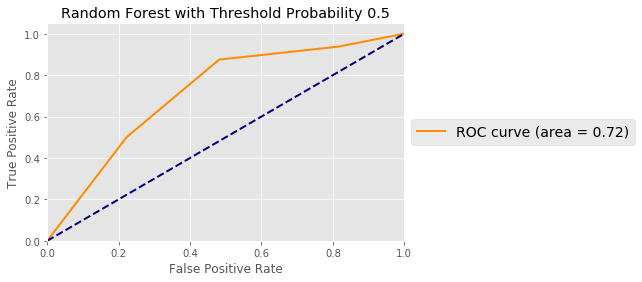

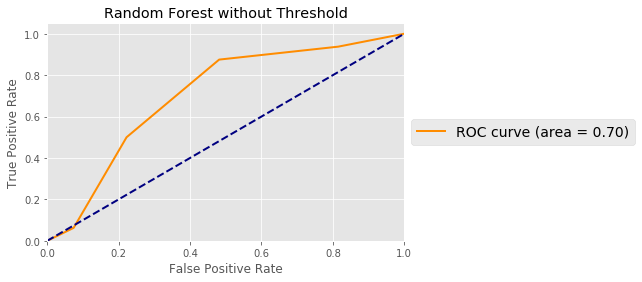

In [37]:
from sklearn.ensemble import RandomForestClassifier 
from model.train_model import report_model_performance
from visualization.visualize import plot_ROC_curve
from sklearn.metrics import accuracy_score

features_to_use = trackspoints_per_timeinterval

# Train Test Split
y = list(features_to_use["rating"])
y = [1 if (i==1 or i==2) else 0 for i in y]
print("Number of 1: ", sum([1 if i==1 else 0 for i in y]))
print("Number of 0: ", sum([1 if i==0 else 0 for i in y]))
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(features_to_use.drop("rating",axis=1),
                                                    y, test_size=0.33, random_state=random_state)


pipe_rf = Pipeline([('clf', RandomForestClassifier())])
param_grid = [{'clf__n_estimators': [5,10,15,20], 
                'clf__criterion': ["gini","entropy"],
                'clf__max_features': ['auto','sqrt','log2'],
                'clf__random_state': [random_state,123,4,5],
                'clf__class_weight': ["balanced"]}
             ]
gs = GridSearchCV(estimator=pipe_rf, 
                   param_grid=param_grid, 
                   scoring='roc_auc', 
                   #refit="roc_auc",
                   cv=5)
gs = gs.fit(X_train, y_train)
print("Best Score: ",gs.best_score_) 
print("Best Parameters: \n", gs.best_params_)


classifier = gs.best_estimator_

classifier = classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)

probability_threshold = 0.5
traffic_jam_prediction = [1 if prob[1] >= probability_threshold else 0 \
                          for prob in y_score]
traffic_jam_probabilities = [0.99 if prob[1] >= probability_threshold else prob[1] \
                          for prob in y_score]

print("Mean Accuracy no Threshold:\t ", round(classifier.score(X_test,y_test),3))
print("Mean Accuracy with Threshold:\t ", round(accuracy_score(traffic_jam_prediction,y_test),3))
print("prediction probabilities:\n",pd.DataFrame(y_score[0:5],columns=[0,1]))
print("Apply probability threshold at: ", probability_threshold)
print("Prediction:\n", traffic_jam_prediction[0:10])
print("True Label:\n", [i for i in y_test[0:10]])
print("\nConfusion Matrix: \n",confusion_matrix(y_test,traffic_jam_prediction))

prediction_probabilities_class_1 = y_score[:,1]
plot_ROC_curve(y_test, traffic_jam_probabilities, title="Random Forest with Threshold Probability " + str(probability_threshold) )
plot_ROC_curve(y_test, prediction_probabilities_class_1, title="Random Forest without Threshold")




In [9]:
from sklearn.model_selection import validation_curve
pipe_rf = Pipeline([('clf', RandomForestClassifier(random_state=random_state))])

param_grid = [{'clf__n_estimators': [i for i in range(1,25,1)],
                'clf__criterion': ["gini","entropy"],
                'clf__max_features': ['auto','sqrt','log2'],
                'clf__random_state': [random_state,123,4,5],
                'clf__class_weight': ["balanced","balanced_subsample"]}
             ]
param_range = param_grid[0]["clf__n_estimators"]
train_scores, test_scores = \
        validation_curve(estimator=pipe_rf, 
                         X=X_train, 
                         y=y_train, 
                         param_name='clf__n_estimators', 
                         param_range=param_range,
                         cv=5)



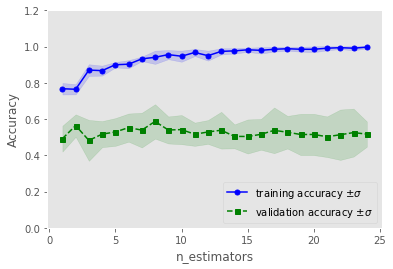

In [10]:
from visualization.visualize import plot_validation_curves
plot_validation_curves(train_scores, test_scores, 
                       param_range, xlabel="n_estimators")

---
### **Upsample Minority Class** **To Do - Cross Validation**

idea from [here](https://elitedatascience.com/imbalanced-classes)

Up-sampling is the process of randomly duplicating observations from the minority class in order to reinforce its signal.

We know that: 
- Number tracks with rating 1 is 14 thats 11% of observations
- Number tracks with rating 2 is 38 thats 29% of observations
- Number tracks with rating 3 is 77 thats 60% of observations

In total we have 129 observations.

In [11]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from visualization.visualize import plot_multiclass_ROC_curve
from sklearn.utils import resample

random_state = 1
tracks = feature_engineered_tracks
df_majority = tracks[tracks["rating"]==3]
df_median = tracks[tracks["rating"]==2]
df_minority = tracks[tracks["rating"]==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=77,    # to match majority class
                                 random_state=random_state) # reproducible results


df_upsampled = pd.concat([df_majority,df_median, df_minority_upsampled])

y = label_binarize(df_upsampled["rating"], classes=[1, 2, 3])
y = pd.DataFrame(y, columns=[1,2,3])


X_train, X_test, y_train, y_test = train_test_split(df_upsampled.drop(drop_columns,axis=1),
                                                    y,
                                                    test_size=test_size, 
                                                    random_state=random_state)

df_upsampled.rating.value_counts()

1    77
3    76
2    38
Name: rating, dtype: int64

ROC-Macro Score:  0.68885


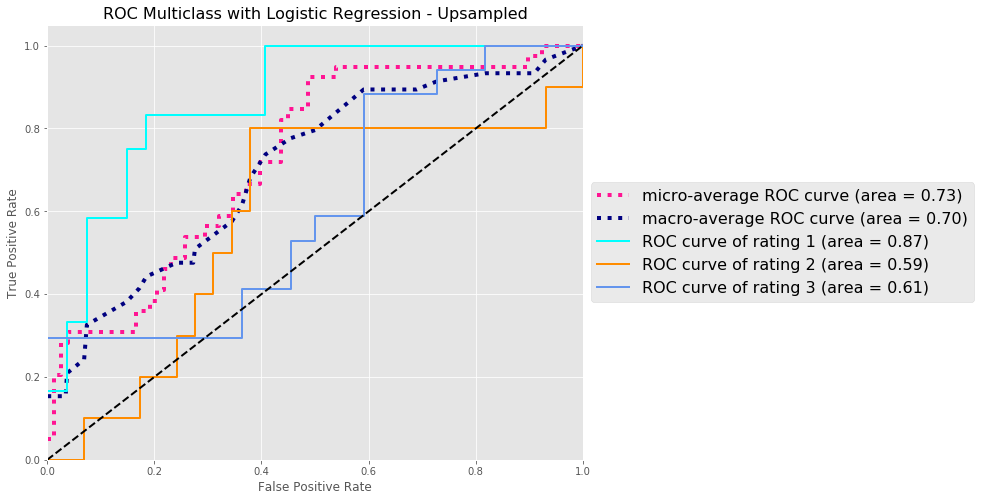

In [12]:
classifier = OneVsRestClassifier(LogisticRegression(random_state=random_state,
                                                    solver="sag"))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)
print("ROC-Macro Score: ",round(roc_auc_score(y_test, 
                                        y_score,
                                        average="macro"),5) )

plot_title = "ROC Multiclass with Logistic Regression - Upsampled"
plot_multiclass_ROC_curve(y_test, y_score, title = plot_title)

---
### **Down-sample Majority Class**

idea from [here](https://elitedatascience.com/imbalanced-classes)

Down-sampling involves randomly removing observations from the majority class to prevent its signal from dominating the learning algorithm.

We know that: 
- Number tracks with rating 1 is 14 thats 11% of observations
- Number tracks with rating 2 is 38 thats 29% of observations
- Number tracks with rating 3 is 77 thats 60% of observations

In total we have 129 observations.

In [39]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from visualization.visualize import plot_multiclass_ROC_curve
from sklearn.utils import resample
random_state = 1
tracks = feature_engineered_tracks
df_majority = tracks[tracks["rating"]==3]
df_median = tracks[tracks["rating"]==2]
df_minority = tracks[tracks["rating"]==1]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,     # sample without replacement
                                 n_samples=14,    # to match minortiy class
                                 random_state=random_state) # reproducible results


df_median_downsampled = resample(df_median, 
                                 replace=False,     # sample without replacement
                                 n_samples=14,    # to match minortiy class
                                 random_state=random_state) # reproducible results


"""
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=38,    # to match majority class
                                 random_state=random_state) # reproducible results

"""

df_downsampled = pd.concat([df_majority_downsampled,df_median_downsampled, df_minority])

y = label_binarize(df_downsampled["rating"], classes=[1, 2, 3])
y = pd.DataFrame(y, columns=[1,2,3])


X_train, X_test, y_train, y_test = train_test_split(df_downsampled.drop(drop_columns,axis=1),
                                                    y,
                                                    test_size=test_size, 
                                                    random_state=random_state)

#WIP
# Add the discarded majority samples to the test set

remaining_majority = df_majority.drop(list(df_majority_downsampled.index))
remaining_median = df_median.drop(list(df_median_downsampled.index))


y_remaining_majority = label_binarize(remaining_majority["rating"], classes=[1, 2, 3])
y_remaining_majority = pd.DataFrame(y_remaining_majority, columns=[1,2,3])
y_remaining_median = label_binarize(remaining_median["rating"], classes=[1, 2, 3])
y_remaining_median = pd.DataFrame(y_remaining_median, columns=[1,2,3])
y_test_concatenated = pd.concat([y_remaining_majority,
                                 y_remaining_median,
                                 y_test])

X_remaining_majority = remaining_majority.drop(drop_columns,axis=1)
X_remaining_median = remaining_median.drop(drop_columns,axis=1)

X_test_concatenated = pd.concat([X_remaining_majority,
                                 X_remaining_median,
                                 X_test])

print("Test Set Size with Discarded: ", len(y_test_concatenated))
print("Test Set Size normal: ", len(y_test))

print("\nComplete Downsampled DataSet")
print(df_downsampled.rating.value_counts())

Test Set Size with Discarded:  95
Test Set Size normal:  9

Complete Downsampled DataSet
3    14
2    14
1    14
Name: rating, dtype: int64


ROC-Macro Score:  0.67037


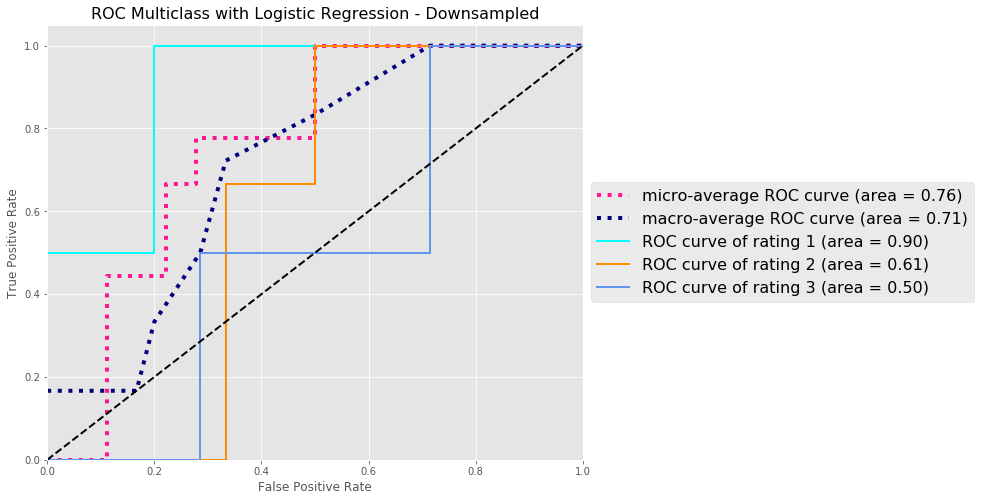

In [14]:
classifier = OneVsRestClassifier(LogisticRegression(random_state=random_state,
                                                    solver="sag"))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)
print("ROC-Macro Score: ",round(roc_auc_score(y_test, 
                                        y_score,
                                        average="macro"),5) )

plot_title = "ROC Multiclass with Logistic Regression - Downsampled"
plot_multiclass_ROC_curve(y_test, y_score, title = plot_title)

ROC-Macro Score:  0.675


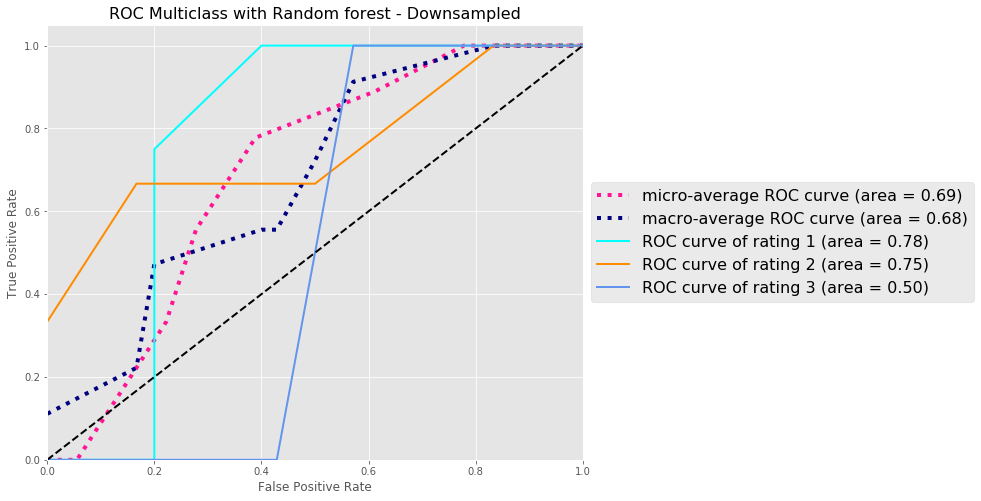

In [15]:
from sklearn.ensemble import RandomForestClassifier 

classifier = OneVsRestClassifier(RandomForestClassifier(random_state=random_state,
                                                        n_estimators = 10))
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)
print("ROC-Macro Score: ",round(roc_auc_score(y_test, 
                                        y_score,
                                        average="macro"),5) )

plot_title = "ROC Multiclass with Random forest - Downsampled"
plot_multiclass_ROC_curve(y_test, y_score, title = plot_title)

In [16]:
from model.train_model import binary_to_multi
prediction = binary_to_multi(y_score)
print("Confusion Matrix")
confusion_matrix(binary_to_multi(np.array(y_test)),prediction)


Confusion Matrix


Predicted label,1,2,3
True label,,,
1,3,0,1
2,1,2,0
3,0,0,2


**Random Forest with concatenated Test Set**

ROC-Macro Score:  0.64058


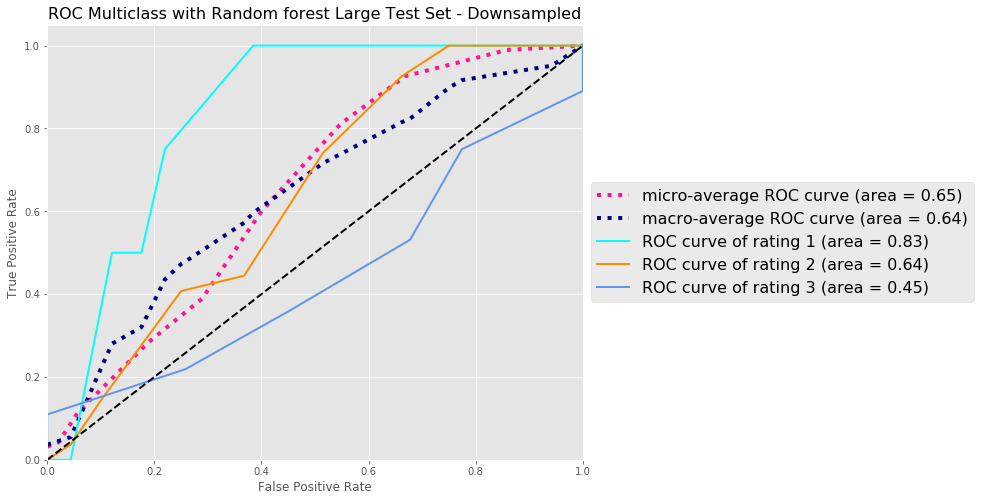

In [17]:
from sklearn.ensemble import RandomForestClassifier 

classifier = OneVsRestClassifier(RandomForestClassifier(random_state=random_state,
                                                        n_estimators = 10))
y_score = classifier.fit(X_train, y_train).predict_proba(X_test_concatenated)
print("ROC-Macro Score: ",round(roc_auc_score(y_test_concatenated, 
                                        y_score,
                                        average="macro"),5) )

plot_title = "ROC Multiclass with Random forest Large Test Set - Downsampled"
plot_multiclass_ROC_curve(y_test_concatenated, y_score, title = plot_title)

In [18]:
from model.train_model import binary_to_multi
prediction = binary_to_multi(y_score)
print("Confusion Matrix")
confusion_matrix(binary_to_multi(np.array(y_test_concatenated)),prediction)

Confusion Matrix


Predicted label,1,2,3
True label,,,
1,3,0,1
2,3,18,6
3,16,28,20


---
### **Majority Vote for traffic rating prediction**

----
### **Use Anomaly Detection for Predicting Rating 1**

---
**MultiClass Prediction with Logistic Regression**

ROC-Macro Score:  0.5924


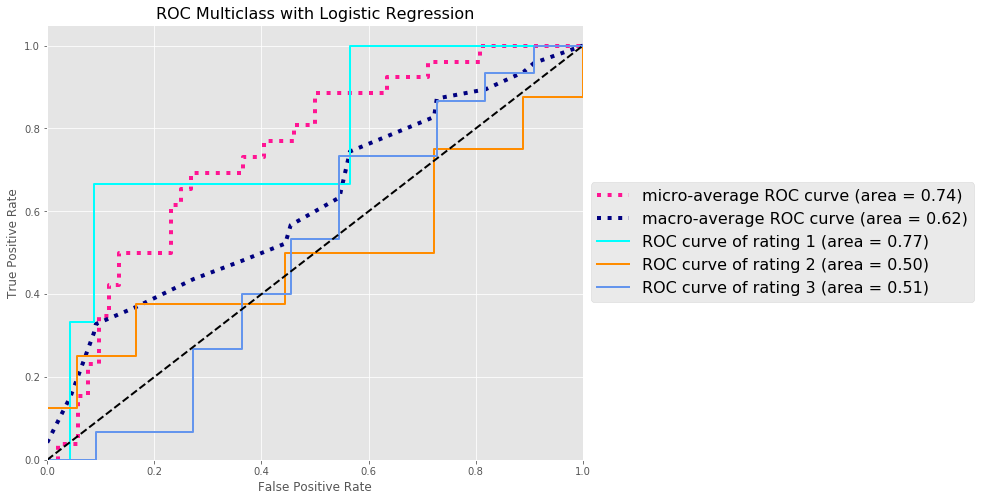

In [19]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from visualization.visualize import plot_multiclass_ROC_curve


y = label_binarize(feature_engineered_tracks["rating"], classes=[1, 2, 3])
y = pd.DataFrame(y, columns=[1,2,3])
random_state = 1
X_train, X_test, y_train, y_test = train_test_split(feature_engineered_tracks.drop(drop_columns,axis=1),
                                                    y,
                                                    test_size=test_size, random_state=random_state)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(LogisticRegression(random_state=random_state,
                                                    solver="sag"))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)
print("ROC-Macro Score: ",round(roc_auc_score(y_test, 
                                        y_score,
                                        average="macro"),5) )

plot_title = "ROC Multiclass with Logistic Regression"
plot_multiclass_ROC_curve(y_test, y_score, title = plot_title)

In [20]:
from model.train_model import binary_to_multi
prediction = binary_to_multi(y_score)
print("Confusion Matrix")
confusion_matrix(binary_to_multi(np.array(y_test)),prediction)


Confusion Matrix


Predicted label,1,2,3
True label,,,
1,0,2,1
2,0,2,6
3,0,2,13


----
**MultiClass Prediction with Random Forest**

Mean Accuracy:	  0.462
ROC-Macro Score:  0.68597


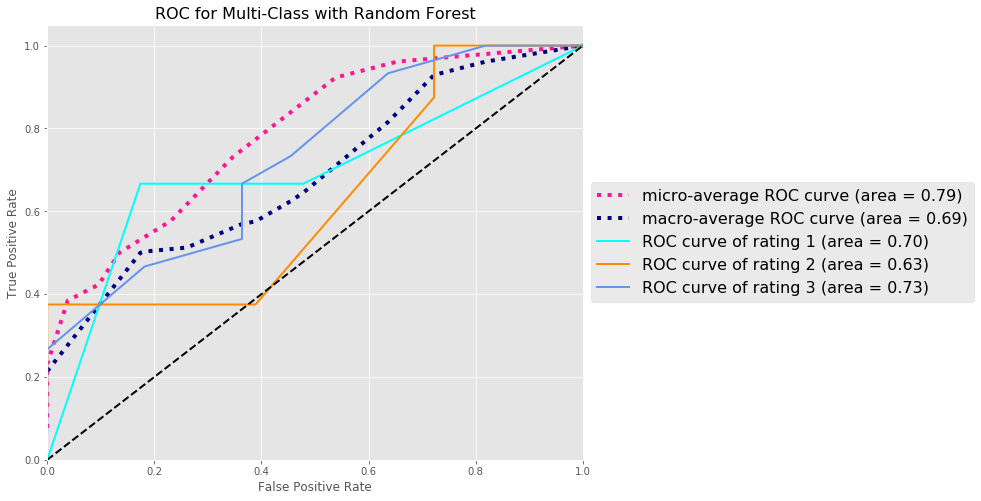

In [21]:
from sklearn.ensemble import RandomForestClassifier 


y = label_binarize(feature_engineered_tracks["rating"], classes=[1, 2, 3])
random_state = 1
X_train, X_test, y_train, y_test = train_test_split(feature_engineered_tracks.drop(drop_columns,axis=1),
                                                    y,
                                                    test_size=test_size, random_state=random_state)

rf_classifier = RandomForestClassifier(random_state=random_state,
                                    oob_score=True)
# Learn to predict each class against the other
rf_classifier = OneVsRestClassifier(rf_classifier)
y_score = rf_classifier.fit(X_train, y_train).predict_proba(X_test)

print("Mean Accuracy:\t ", round(rf_classifier.score(X_test,y_test),3))
print("ROC-Macro Score: ",round(roc_auc_score(y_test, 
                                        y_score,
                                        average="macro"),5) )
plot_multiclass_ROC_curve(y_test, y_score,title="ROC for Multi-Class with Random Forest")


In [22]:
from model.train_model import confusion_matrix
from model.train_model import binary_to_multi

prediction = binary_to_multi(y_score)
confusion_matrix(binary_to_multi(y_test),prediction)

  

Predicted label,1,2,3
True label,,,
1,1,2,0
2,0,3,5
3,1,1,13


---
### **Use Binary Predictor**
- 1 == Traffic Jam
- 0 == No Traffic Jam

Assigned to **1-Traffic Jam** all ratings with 1 or 2 and ratings with 3 to **0-No Traffic Jam**

In [23]:
# Train Test Split
y = list(feature_engineered_tracks["rating"])
y = [1 if (i==1 or i==2) else 0 for i in y]
print("Number of 1: ", sum([1 if i==1 else 0 for i in y]))
print("Number of 0: ", sum([1 if i==0 else 0 for i in y]))
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(feature_engineered_tracks.drop(drop_columns,axis=1),
                                                    y, test_size=test_size, random_state=random_state)

Number of 1:  52
Number of 0:  76


**Binary Class Prediction with Logistic Regression**

Mean Accuracy:	  0.577
Coefficients: 
    distance  car_or_bus  month_sinus  month_cosinus  weekday_sinus  \
0 -0.200754   -0.023559     0.464537       0.109516       0.030351   

   weekday_cosinus  daytime_start_sinus  daytime_start_cosinus  
0         0.346123            -0.282378                0.29971  


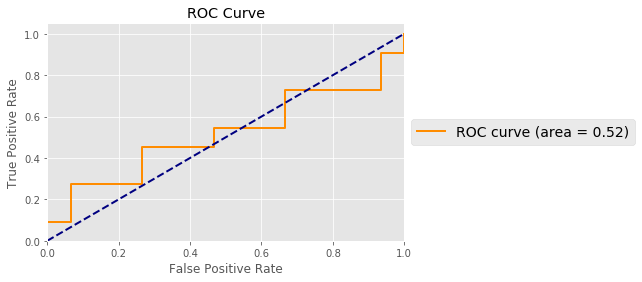

In [24]:
from sklearn.linear_model import LogisticRegression
from model.train_model import report_model_performance
from visualization.visualize import plot_ROC_curve
from sklearn.metrics import accuracy_score

# Learn to predict each class against the other
classifier = OneVsRestClassifier(LogisticRegression(random_state=random_state,
                                                    penalty = "l2"
                                                    ))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)
print("Mean Accuracy:\t ", round(classifier.score(X_test,y_test),3))

coefficients = pd.DataFrame(classifier.coef_, columns=[X_train.columns.values])
print("Coefficients: \n", coefficients)

plot_ROC_curve(y_test, y_score)

**Binary Class Prediction with Random Forest and Threshold**

Mean Accuracy no Threshold:	  0.692
Mean Accuracy with Threshold:	  0.654
prediction probabilities:
       0     1
0  0.76  0.24
1  0.26  0.74
2  0.78  0.22
3  0.74  0.26
4  0.72  0.28
Apply probability threshold at:  0.49
Prediction:
 [0, 1, 0, 0, 0, 0, 0, 1, 1, 1]
True Label:
 [1, 0, 0, 0, 1, 0, 0, 1, 1, 1]

Confusion Matrix: 
 Predicted label   0  1
True label            
0                11  4
1                 5  6


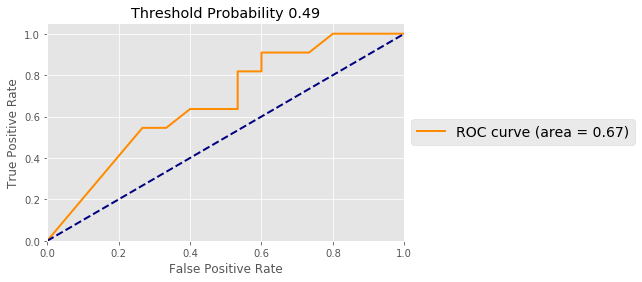

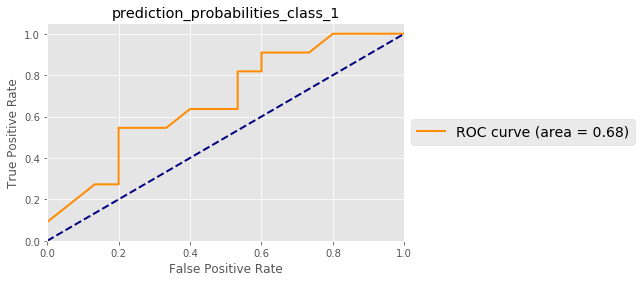

In [25]:
from sklearn.ensemble import RandomForestClassifier 
classifier = RandomForestClassifier(random_state=random_state,
                                    n_estimators = 50,
                                    #criterion = "entropy",
                                    #oob_score=True
                                    )

classifier = classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)

probability_threshold = 0.49
traffic_jam_prediction = [1 if prob[1] >= probability_threshold else 0 \
                          for prob in y_score]
traffic_jam_probabilities = [0.99 if prob[1] >= probability_threshold else prob[1] \
                          for prob in y_score]

print("Mean Accuracy no Threshold:\t ", round(classifier.score(X_test,y_test),3))
print("Mean Accuracy with Threshold:\t ", round(accuracy_score(traffic_jam_prediction,y_test),3))
print("prediction probabilities:\n",pd.DataFrame(y_score[0:5],columns=[0,1]))
print("Apply probability threshold at: ", probability_threshold)
print("Prediction:\n", traffic_jam_prediction[0:10])
print("True Label:\n", [i for i in y_test[0:10]])
print("\nConfusion Matrix: \n",confusion_matrix(y_test,traffic_jam_prediction))

prediction_probabilities_class_1 = y_score[:,1]
plot_ROC_curve(y_test, traffic_jam_probabilities, title="Threshold Probability " + str(probability_threshold) )
plot_ROC_curve(y_test, prediction_probabilities_class_1, title="prediction_probabilities_class_1")



**Validation Curves - To visualize problem of overfitting**

We can see that the random forest model is very prone to overfitting in regard to its number of estimators in the ensemble. This could be due to the small amount of data.

In [26]:
from sklearn.model_selection import validation_curve
pipe_rf = Pipeline([('clf', RandomForestClassifier(random_state=random_state))])

param_grid = [{'clf__n_estimators': [i for i in range(1,31,1)],#[5,10,15,20,25,30,35, 40,45,50], 
                'clf__criterion': ["gini","entropy"],
                'clf__max_features': ['auto','sqrt','log2'],
                'clf__random_state': [random_state,123,4,5],
                'clf__class_weight': ["balanced","balanced_subsample"]}
             ]
param_range = param_grid[0]["clf__n_estimators"]
train_scores, test_scores = \
        validation_curve(estimator=pipe_rf, 
                         X=X_train, 
                         y=y_train, 
                         param_name='clf__n_estimators', 
                         param_range=param_range,
                         cv=5)

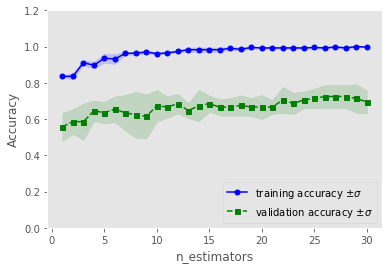

In [27]:
from visualization.visualize import plot_validation_curves
plot_validation_curves(train_scores, test_scores, 
                       param_range, xlabel="n_estimators")

**Binary Class Prediction with Random Forest and 5 fold Cross Validation + Hyperparameter Tuning**

In [28]:
from sklearn.ensemble import RandomForestClassifier 

pipe_rf = Pipeline([('clf', RandomForestClassifier())])
param_grid = [{'clf__n_estimators': [1,2,3,4,5,10,15,20], 
                'clf__criterion': ["gini","entropy"],
                'clf__max_features': ['auto','sqrt','log2'],
                'clf__random_state': [random_state,123,4,5],
                'clf__class_weight': ["balanced","balanced_subsample"]}
             ]
gs = GridSearchCV(estimator=pipe_rf, 
                   param_grid=param_grid, 
                   scoring='roc_auc', 
                   #refit="roc_auc",
                   cv=10,
                   n_jobs=-1)
gs = gs.fit(X_train, y_train)
print("Best Score: ",gs.best_score_) 
print("Best Parameters: \n", gs.best_params_)

Best Score:  0.763585434174
Best Parameters: 
 {'clf__random_state': 5, 'clf__n_estimators': 5, 'clf__max_features': 'log2', 'clf__criterion': 'entropy', 'clf__class_weight': 'balanced'}


Mean Accuracy:	  0.615
Prediction:
 [0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1]
True Label:
 [1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0]

Confusion Matrix: 
 Predicted label   0  1
True label            
0                10  5
1                 5  6


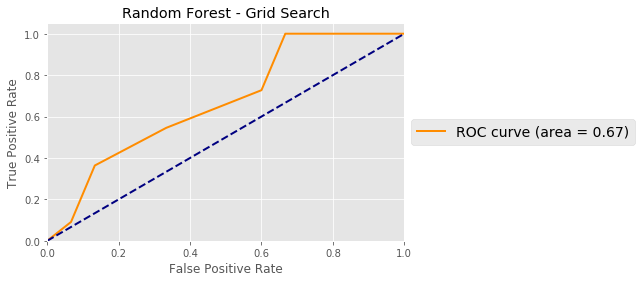

In [29]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
y_score = clf.predict_proba(X_test)
prediction = clf.predict(X_test)

print("Mean Accuracy:\t ", round(clf.score(X_test, y_test),3))

print("Prediction:\n", [i for i in prediction])
print("True Label:\n", [i for i in y_test])
print("\nConfusion Matrix: \n",confusion_matrix(y_test, prediction))

prediction_probabilities_class_1 = y_score[:,1]
plot_ROC_curve(y_test, prediction_probabilities_class_1, title="Random Forest - Grid Search")



**Binary Class Prediction with Support Vector Machine and 5 fold Cross Validation + Hyperparameter Tuning**

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
pipe_svc = Pipeline([('clf', SVC(random_state=random_state))])
param_range = [0.001, 0.01, 0.1, 1.0,5.0, 10.0,15.0, 20.0,30.0, 100.0,150.0]
param_grid = [{'clf__C': param_range, 
                'clf__gamma': param_range,
                'clf__kernel': ['poly','rbf','sigmoid'],
                'clf__class_weight': ["balanced"]}
             ]
gs = GridSearchCV(estimator=pipe_svc, 
                   param_grid=param_grid, 
                   scoring='roc_auc', 
                   #refit="roc_auc",
                   cv=5,
                   n_jobs=-1)
gs = gs.fit(X_train, y_train)
print("Best Score: ",gs.best_score_) 
print("Best Parameters: \n", gs.best_params_)

Best Score:  0.67035361153
Best Parameters: 
 {'clf__gamma': 0.1, 'clf__kernel': 'rbf', 'clf__C': 5.0, 'clf__class_weight': 'balanced'}


Mean Accuracy:	  0.654
Prediction:
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 1]
True Label:
 [1, 0, 0, 0, 1, 0, 0, 1, 1, 1]

Confusion Matrix: 
 Predicted label   0  1
True label            
0                11  4
1                 5  6


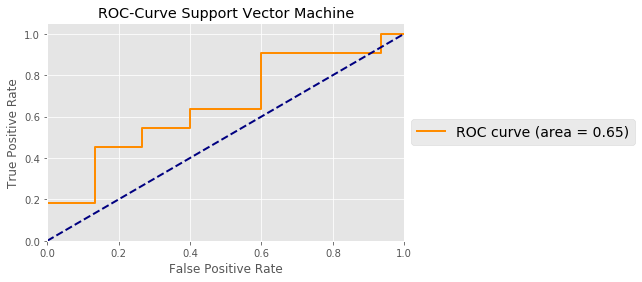

In [31]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
y_score = clf.decision_function(X_test)
prediction = clf.predict(X_test)

print("Mean Accuracy:\t ", round(clf.score(X_test, y_test),3))

print("Prediction:\n", [i for i in prediction[0:10]])
print("True Label:\n", [i for i in y_test[0:10]])
print("\nConfusion Matrix: \n",confusion_matrix(y_test, prediction))

plot_ROC_curve(y_test, y_score, title="ROC-Curve Support Vector Machine")

